## 7)


Для начала, нам нужно решить задачу аналитически.

$$-u''(x) + u(x) = x,\;\;0 \leqslant x \leqslant 1,\;\;u(0) = u(1) = 0$$

Рассмотрим соответствующее однородное уравнение.

$$-u''(x) + u(x) = 0$$

$$x^2 - 1 = 0$$

Корни $x \in \{-1, 1\}$, оба кратности один.

Тогда общее решение имеет вид $$c_1 e^{x} + c_2 e^{-x}$$

Возвращаемся к исходному неоднородному.

Рассмотрим частное решение $u(x) = x$ неоднородного уравнения 

$$-u''(x) + u(x) = x$$

Мы можем получть общее решение неоднородного урванения как сумму общего решения однородного и частного решения неоднородного, тем самым общее решение неоднородного имеет вид:

$$c_1 e^{x} + c_2 e^{-x} + x$$

Осталось подобрать константы (подставим точки x = 0, x = 1):

\begin{equation*}
\begin{cases}
c_1 + c_2 = 0 \\
c_1 e + \frac{c_2}{e} = -1
\end{cases}
\Leftrightarrow
\begin{cases}
c_2 = -c_1 \\
c_1 e + \frac{c_2}{e} = -1
\end{cases}
\Leftrightarrow
\begin{cases}
c_1 = \frac{1}{\frac{1}{e} - e} \\
c_2 = \frac{-1}{\frac{1}{e} - e}
\end{cases}
\end{equation*}

Итого:
    
$$u(x) = \frac{1}{\frac{1}{e} - e} \cdot (e^x - e^{-x}) + x = \frac{e \cdot (e^{x} - e^{-x})}{1 - e^2} + x$$

Теперь опишем функцию для нахождения точного решения:

In [37]:
import numpy as np

def get_u(x):
    return x + (np.exp(1 + x) - np.exp(1 - x)) / (1 - np.exp(2))

Теперь опишем функции для нахождения $A$ и $b$ (мы помним, что $u(0) = u(1) = 0$, а стало быть 

$$u(x_0) = u(x_{N + 1}) = 0$$ 

и матрица $A$ действительно будет трехдиагональной).

In [40]:
def get_A(N):
    h = 1.0 / (N + 1)
    A = []
    for i in range(N):
        current = []
        for j in range(i - 1):
            current.append(0)
        if i > 0:
            current.append(-h**(-2))
        current.append(2 * h**(-2) + 1)
        if i < N - 1:
            current.append(-h**(-2))
        for j in range(N - i - 2):
            current.append(0)
        A.append(current)
    return np.array(A)

In [41]:
get_A(4)

array([[ 51., -25.,   0.,   0.],
       [-25.,  51., -25.,   0.],
       [  0., -25.,  51., -25.],
       [  0.,   0., -25.,  51.]])

In [7]:
def get_b(N):
    h = 1.0 / (N + 1)
    return np.array([h * i for i in range(1, N + 1)])

In [26]:
get_b(4)

array([0.2, 0.4, 0.6, 0.8])

В качестве стандартного способа решать СЛАУ рассмотрим numpy.linalg.solve.
Также скопируем функцию для постороения графиков из предыдущих домашек.

In [9]:
import matplotlib.pyplot as plt

def build_plot(xs, ys, xlabel='', ylabel='', title='', filename='plot', 
               plot_labels=None, color_shapes=None, points=None):
    xs = np.array(xs)
    ys = np.array(ys)
    if xs.ndim == 1:
        xs = np.array([xs])
        ys = np.array([ys])
    if color_shapes is None:
        color_shapes = ['' for _ in range(xs.shape[0] if xs.ndim > 1 else 1)]
    
    plt.clf()
    if points is not None:
        plt.plot(points[0], points[1], 'ro')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    for ind, (x, y) in enumerate(zip(xs, ys)):
        if plot_labels is not None:
            plt.plot(x, y, color_shapes[ind], label=plot_labels[ind])
        else:
            plt.plot(x, y, color_shapes[ind])
    if plot_labels is not None:
        plt.legend()
    plt.show()

In [42]:
def get_u_vector_standart_solver(N):
    A = get_A(N)
    b = get_b(N)
    return np.linalg.solve(A, b)

def get_u_vector(N):
    h = 1.0 / (N + 1)
    return np.array([get_u(h * i) for i in range(1, N + 1)])

Построим график зависимости погрешшности от $N$. Погрешность будем рассматривать, как максимум погрешности в точках $x_i$.

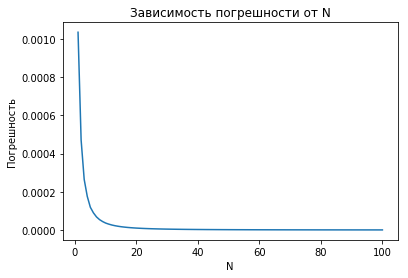

In [44]:
Ns = range(1, 101)
build_plot(Ns, [np.amax(np.abs(get_u_vector_standart_solver(N) - get_u_vector(N))) for N in Ns], 
           'N', 'Погрешность', 'Зависимость погрешности от N')

Реализуем метод прогонки.

Для начала, заметим, что в нашем случае 

$$2h^{-2} + 1 = |c_i| > |a_i| + |b_i| = 2h^2,$$ 

то есть выполняется достаточное условие разрешимости прогонки.

In [55]:
def tridiagonal_algo_solver(a, b, c, d):
    N = len(a)
    alphas = [b[0] / c[0]]
    betas = [d[0] / c[0]]
    for i in range(N - 1):
        alphas.append(b[i + 1] / (c[i + 1] - alphas[-1] * a[i + 1]))
        betas.append((d[i + 1] + betas[-1] * a[i + 1]) / (c[i + 1] - alphas[-1] * a[i + 1]))
    ans = [0 for _ in range(N)]
    ans[N - 1] = betas[-1]
    for i in range(N - 2, -1, -1):
        ans[i] = ans[i + 1] * alphas[i] + betas[i]
    return np.array(ans)

In [56]:
def get_u_vector_tridiagonal_algo_solver(N):
    h = 1.0 / (N + 1)
    a = [-h**(-2) for _ in range(N)]
    b = [-h**(-2) for _ in range(N)]
    c = [2 * h**(-2) + 1 for _ in range(N)]
    d = get_b(N)
    return tridiagonal_algo_solver(a, b, c, d)

Построим график зависимости погрешности от $N$

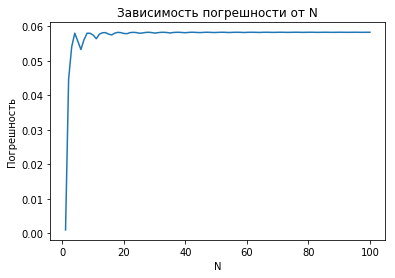

In [57]:
Ns = range(1, 101)
build_plot(Ns, [np.amax(np.abs(get_u_vector_tridiagonal_algo_solver(N) - get_u_vector(N))) for N in Ns], 
           'N', 'Погрешность', 'Зависимость погрешности от N')